<a href="https://colab.research.google.com/github/pvannies/Teaching/blob/main/Text_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  **Working with Text Data**

*A notebook for hands-on experience in the Data Science for Business course with text analysis, following Chapter 7 from **Introduction to Machine Learning with Python**.
Small changes are made to the code compared to the book in order to make it work with newer scikit-learn versions, and not all text is exactly copied, instead some questions are asked to check your understanding.*

What different kinds of text data are there? Inspect your data to find out what kind of string data you have:

- Categorical data
  - data that comes from a fixed list
  - example: drop-down menu favorite color: ["red", "green", "blue"]
  - confirm by computing the unique values over the dataset
- Free strings that can be semantically mapped to categories
  - data that comes from a free text field
  - example: text field for favorite color: "gray", "grey", "color of the sky upon sunset", "purple", "fuchsia" etc.
  - encode data as categorical variable, defining categories that will capture responses in a way that makes sense for your application
- Structured string data
  - no fixed category, but with underlying structure.
  - example: addresses, names of places or people, dates etc.
  - parse with regex or named entity recognition techniques (out of scope for now)
- **Text data**
  - data that consists of phrases or sentences composed of words.
  - example: works of Shakespeare, Wikipedia, news articles, tweets.
  - dataset is called the **corpus**, each datapoint, a single text is called a **document**.


# Example application: **Sentiment analysis** of Movie reviews

As a running example in this chapter, we will use a dataset of movie reviews from the
IMDb (Internet Movie Database) website collected by Stanford researcher Andrew
Maas.
 This dataset contains the text of the reviews, together with a label that indicates whether a review is “**positive**” or “**negative**.” The IMDb website itself contains
ratings from 1 to 10. To simplify the modeling, this annotation is summarized as a
two-class classification dataset where *reviews with a score of 6 or higher are labeled as
positive* , and the rest as negative.


- download the dataset here: http://ai.stanford.edu/~amaas/data/sentiment/
- upload it to the sample_data folder that you see on the left when clicking on the folder icon

info:
**Large Movie Review Dataset**

*This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. We provide a set of 25,000 highly polar movie reviews for training, and 25,000 for testing. There is additional unlabeled data for use as well. Raw text and already processed bag of words formats are provided. See the README file contained in the release for more details.*




In [ ]:
# unpack the file and delete what we don't need.
!tar -xvzf sample_data/aclImdb_v1.tar.gz > /dev/null 2>&1
!rm -r aclImdb/train/unsup > /dev/null 2>&1

In [ ]:
# show the structure of the folder
!apt-get install tree > /dev/null 2>&1
!tree -dL 2 aclImdb

aclImdb
├── test
│   ├── neg
│   └── pos
└── train
    ├── neg
    └── pos

6 directories


In [ ]:
import sklearn
from sklearn.datasets import load_files
from pprint import pprint
print(f"sklearn version: {sklearn.__version__}")
# sklearn reference: https://scikit-learn.org/stable/index.html

sklearn version: 1.5.2


In [ ]:
reviews_train = load_files("aclImdb/train/")

text_train, y_train = reviews_train.data, reviews_train.target

print(f"type of text_train: {type(text_train)}")
print(f"length of text_train: {len(text_train)}")
pprint(f"text_train[0]:\n {text_train[0]}")

type of text_train: <class 'list'>
length of text_train: 25000
('text_train[0]:\n'
 ' b"Zero Day leads you to think, even re-think why two boys/young men would '
 'do what they did - commit mutual suicide via slaughtering their classmates. '
 'It captures what must be beyond a bizarre mode of being for two humans who '
 'have decided to withdraw from common civility in order to define their '
 'own/mutual world via coupled destruction.<br /><br />It is not a perfect '
 'movie but given what money/time the filmmaker and actors had - it is a '
 'remarkable product. In terms of explaining the motives and actions of the '
 "two young suicide/murderers it is better than 'Elephant' - in terms of being "
 "a film that gets under our 'rationalistic' skin it is a far, far better film "
 'than almost anything you are likely to see. <br /><br />Flawed but honest '
 'with a terrible honesty."')


In [ ]:
# The review contains some HTML line breaks.
# It is best to clean this data before we proceed.
text_train = [doc.replace(b"<br />",b" ") for doc in text_train]
pprint(f"text_train[0]:\n {text_train[0]}")

('text_train[0]:\n'
 ' b"Zero Day leads you to think, even re-think why two boys/young men would '
 'do what they did - commit mutual suicide via slaughtering their classmates. '
 'It captures what must be beyond a bizarre mode of being for two humans who '
 'have decided to withdraw from common civility in order to define their '
 'own/mutual world via coupled destruction.  It is not a perfect movie but '
 'given what money/time the filmmaker and actors had - it is a remarkable '
 'product. In terms of explaining the motives and actions of the two young '
 "suicide/murderers it is better than 'Elephant' - in terms of being a film "
 "that gets under our 'rationalistic' skin it is a far, far better film than "
 'almost anything you are likely to see.   Flawed but honest with a terrible '
 'honesty."')


In [ ]:
# How balanced is our dataset?
import numpy as np
print(f"Samples per class (training): {np.bincount(y_train)}")

Samples per class (training): [12500 12500]


In [ ]:
reviews_test = load_files("aclImdb/test/")

text_test, y_test = reviews_test.data, reviews_test.target

print(f"Number of documents in test data: {len(text_test)}")
print(f"Samples per class (test): {np.bincount(y_test)}")
# apply the same data cleaning to the test dataset as is done for the train dataset
text_test = [doc.replace(b"<br />",b" ") for doc in text_test]
pprint(f"text_test[0]:\n {text_test[0]}")

Number of documents in test data: 25000
Samples per class (test): [12500 12500]
('text_test[0]:\n'
 ' b"Don\'t hate Heather Graham because she\'s beautiful, hate her because '
 "she's fun to watch in this movie. Like the hip clothing and funky "
 'surroundings, the actors in this flick work well together. Casey Affleck is '
 'hysterical and Heather Graham literally lights up the screen. The minor '
 'characters - Goran Visnjic {sigh} and Patricia Velazquez are as TALENTED as '
 'they are gorgeous. Congratulations Miramax & Director Lisa Krueger!"')


# Representing Data as a Bag of Words

**bag-of-words**: *represents how often each word appears in each text.*

Most of the structure of the input text, like chapters, paragraphs, sentemces and formatting is discarded. See it really as a bag with word counts.

Three steps are involved:

1. *Tokenization* Each document is splitted into the words that appear in it, for example by splitting them on whitespace and punctuation.
2. *Vocabulary building*. Collect a vocabulary of all words that appear in any of the
documents, and number them (say, in alphabetical order).
3. *Encoding*. For each document, count how often each of the words in the vocabulary appear in this document.

The output is ***one vector*** of word counts for ***each document***. For each word in the vocabulary, we have a count of how often it appears in
each document. That means our **numeric representation** has *one feature for each unique word* in the whole dataset.

See below the example from the book, where one example document is given.


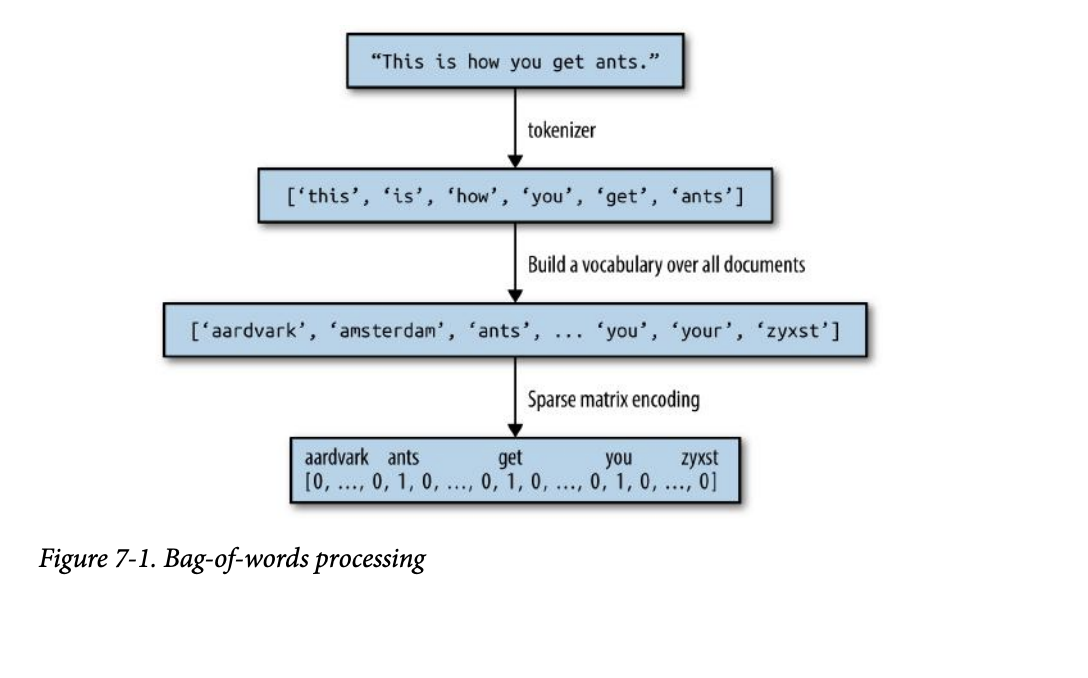



In [ ]:
bards_words =["The fool doth think he is wise,",
 "but the wise man knows himself to be a fool"]

we use the [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html] ) for the bag-of-words implementation.  

- the vocabulary is accesible as the *vocabulary_* attribute after the fit method.
- the numeric representation is made with the transform method.

In [ ]:
# We first instantiate it and then fit it to our data example:
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer()
vect.fit(bards_words)

print(f"Vocabulary size: {len(vect.vocabulary_)}")
print(f"Vocabulary content:\n {vect.vocabulary_}")

Vocabulary size: 13
Vocabulary content:
 {'the': 9, 'fool': 3, 'doth': 2, 'think': 10, 'he': 4, 'is': 6, 'wise': 12, 'but': 1, 'man': 8, 'knows': 7, 'himself': 5, 'to': 11, 'be': 0}


In [ ]:
bag_of_words = vect.transform(bards_words)
# sparse representation, only non-zero values are stored
print("bag_of_words: {}".format(repr(bag_of_words)))
# dense representation:
print(f"Dense representation of bag_of_words:\n{bag_of_words.toarray()}")
# Stop and think: do you understand how to read these feature vectors?

bag_of_words: <2x13 sparse matrix of type '<class 'numpy.int64'>'
	with 16 stored elements in Compressed Sparse Row format>
Dense representation of bag_of_words:
[[0 0 1 1 1 0 1 0 0 1 1 0 1]
 [1 1 0 1 0 1 0 1 1 1 0 1 1]]


# Bag-of-words for Movie Reviews

Let's apply it to our task of sentiment analysis for movie reviews.

We will proces the training and test data from the IMDb reviews.

In [ ]:
vect = CountVectorizer().fit(text_train)
X_train = vect.transform(text_train)
print("X_train:\n{}".format(repr(X_train)))

# Stop and think: How many entries does the vocabulary contain?

X_train:
<25000x74849 sparse matrix of type '<class 'numpy.int64'>'
	with 3431196 stored elements in Compressed Sparse Row format>


In [ ]:
feature_names = vect.get_feature_names_out()
print(f"Number of features: {len(feature_names)}")
print(f"First 20 features:\n{feature_names[:20]}")
print(f"Features 20010 to 20030:\n{feature_names[20010:20030]}")
print(f"Every 2000th feature:\n{feature_names[::2000]}")

# Stop and think:
# Are the first 10 features meaningfull?  Which of the first 20 might be meaningful?
# Does it make sense to count "drawer" and "drawers" as different words?

Number of features: 74849
First 20 features:
['00' '000' '0000000000001' '00001' '00015' '000s' '001' '003830' '006'
 '007' '0079' '0080' '0083' '0093638' '00am' '00pm' '00s' '01' '01pm' '02']
Features 20010 to 20030:
['dratted' 'draub' 'draught' 'draughts' 'draughtswoman' 'draw' 'drawback'
 'drawbacks' 'drawer' 'drawers' 'drawing' 'drawings' 'drawl' 'drawled'
 'drawling' 'drawn' 'draws' 'draza' 'dre' 'drea']
Every 2000th feature:
['00' 'aesir' 'aquarian' 'barking' 'blustering' 'bête' 'chicanery'
 'condensing' 'cunning' 'detox' 'draper' 'enshrined' 'favorit' 'freezer'
 'goldman' 'hasan' 'huitieme' 'intelligible' 'kantrowitz' 'lawful' 'maars'
 'megalunged' 'mostey' 'norrland' 'padilla' 'pincher' 'promisingly'
 'receptionist' 'rivals' 'schnaas' 'shunning' 'sparse' 'subset'
 'temptations' 'treatises' 'unproven' 'walkman' 'xylophonist']


Before we try to improve our feature extraction, let’s obtain a quantitative measure of
performance by actually building a classifier. We have the training labels stored in
*y_train* and the bag-of-words representation of the training data in *X_train*, so we
can train a classifier on this data. For high-dimensional, sparse data like this, linear
models like LogisticRegression often work best.
Let’s start by evaluating LogisticRegresssion using **[cross-validation](https://scikit-learn.org/stable/modules/cross_validation.html)**:

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression, SGDClassifier, RidgeClassifier
from sklearn.svm import LinearSVC

# model = LogisticRegression(C=0.1, solver='sag') this did not converge
# an SGDclassifier scales better with large data
model = SGDClassifier()
model_fit = model.fit(X_train, y_train)

print(f"Training set score: {model_fit.score(X_train, y_train):.3f}")


Training set score: 0.976


In [ ]:
scores = cross_val_score(model, X_train, y_train, cv=5)
print(f"Mean cross-validation accuracy: {np.mean(scores):.2f}")


Mean cross-validation accuracy: 0.87


In [ ]:
X_test = vect.transform(text_test)
print(f"Test set score: {model_fit.score(vect.transform(text_test), y_test):.3f}")


Test set score: 0.849


In [ ]:
# Is it hard to generalize to new data?
# Is this model over- or underfitting?

Now, let’s see if we can improve the extraction of words. The CountVectorizer
extracts tokens using a regular expression. By default, the regular expression that is
used is "\b\w\w+\b". If you are not familiar with regular expressions, this means it
finds all sequences of characters that consist of at least two letters or numbers (\w)
and that are separated by word boundaries (\b). It does not find single-letter words,
and it splits up contractions like “doesn’t” or “bit.ly”, but it matches “h8ter” as a single
word. The CountVectorizer then converts all words to lowercase characters, so that
“soon”, “Soon”, and “sOon” all correspond to the same token (and therefore feature).
This simple mechanism works quite well in practice, but as we saw earlier, we get
many uninformative features (like the numbers). One way to cut back on these is to
only use tokens that appear in at least two documents (or at least five documents, and
so on). A token that appears only in a single document is unlikely to appear in the test
set and is therefore not helpful. We can set the minimum number of documents a
token needs to appear in with the min_df parameter:

In [ ]:
vect = CountVectorizer(min_df=5).fit(text_train)
X_train = vect.transform(text_train)
print(f"X_train with min_df: {repr(X_train)}")

# How did the requirement to be a token only if there are at least five appearances,
# change the size of features?

X_train with min_df: <25000x27271 sparse matrix of type '<class 'numpy.int64'>'
	with 3354014 stored elements in Compressed Sparse Row format>


In [ ]:
feature_names = vect.get_feature_names_out()

print(f"First 50 features:\n{feature_names[:50]}")
print(f"Features 20010 to 20030:\n{feature_names[20010:20030]}")
print(f"Every 700th feature:\n{feature_names[::700]}")

# What do you now observe for the numbers in the first 50 features?

First 50 features:
['00' '000' '007' '00s' '01' '02' '03' '04' '05' '06' '07' '08' '09' '10'
 '100' '1000' '100th' '101' '102' '103' '104' '105' '107' '108' '10s'
 '10th' '11' '110' '112' '116' '117' '11th' '12' '120' '12th' '13' '135'
 '13th' '14' '140' '14th' '15' '150' '15th' '16' '160' '1600' '16mm' '16s'
 '16th']
Features 20010 to 20030:
['repentance' 'repercussions' 'repertoire' 'repetition' 'repetitions'
 'repetitious' 'repetitive' 'rephrase' 'replace' 'replaced' 'replacement'
 'replaces' 'replacing' 'replay' 'replayable' 'replayed' 'replaying'
 'replays' 'replete' 'replica']
Every 700th feature:
['00' 'affections' 'appropriately' 'barbra' 'blurbs' 'butchered' 'cheese'
 'commitment' 'courts' 'deconstructed' 'disgraceful' 'dvds' 'eschews'
 'fell' 'freezer' 'goriest' 'hauser' 'hungary' 'insinuate' 'juggle'
 'leering' 'maelstrom' 'messiah' 'music' 'occasional' 'parking'
 'pleasantville' 'pronunciation' 'recipient' 'reviews' 'sas' 'shea'
 'sneers' 'steiger' 'swastika' 'thrusting' 't

In [ ]:
# Let's fit the same model again.

scores = cross_val_score(model, X_train, y_train, cv=5)
print(f"Mean cross-validation accuracy: {np.mean(scores):.2f}")

# The score seems unchanged, but what benefit did we achieve?

Mean cross-validation accuracy: 0.87


# Stopwords
Another way that we can get rid of uninformative words is by discarding words that
are too frequent to be informative. There are two main approaches: using a languagespecific list of stopwords, or discarding words that appear too frequently. scikitlearn has a built-in list of English stopwords in the feature_extraction.text
module:


In [ ]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
print(f"Number of stop words: {len(ENGLISH_STOP_WORDS)}")
pprint(f"Every 10th stopword:\n{list(ENGLISH_STOP_WORDS)[::10]}")


Number of stop words: 318
('Every 10th stopword:\n'
 "['without', 'nor', 'onto', 'his', 'put', 'noone', 'four', 'of', 'inc', "
 "'too', 'within', 'hers', 'myself', 'yet', 'being', 'show', 'moreover', "
 "'others', 'not', 'former', 'until', 'something', 'please', 'alone', 'less', "
 "'been', 'around', 'if', 'indeed', 'toward', 'get', 'yours']")


In [ ]:
# Specifying stop_words="english" uses the built-in list.
# We could also augment it and pass our own.
vect = CountVectorizer(min_df=5, stop_words="english").fit(text_train)
X_train = vect.transform(text_train)
print(f"X_train with stop words:\n{repr(X_train)}")
# Are there indeed 318 fewer features in the dataset?

X_train with stop words:
<25000x26966 sparse matrix of type '<class 'numpy.int64'>'
	with 2149958 stored elements in Compressed Sparse Row format>


In [ ]:
scores = cross_val_score(model, X_train, y_train, cv=5)
print(f"Mean cross-validation accuracy: {np.mean(scores):.2f}")

# Did the performance increase?
# Is it useful to use this list?

Mean cross-validation accuracy: 0.86


The performance decreased slightly using the stopwords—not enough to
worry about, but given that excluding 305 features out of over 27,000 is unlikely to
change performance or interpretability a lot, it doesn’t seem worth using this list.
Fixed lists are mostly helpful for small datasets, which might not contain enough
information for the model to determine which words are stopwords from the data
itself. As an exercise, you can try out the other approach, discarding frequently
appearing words, by setting the max_df option of CountVectorizer and see how it
influences the number of features and the performance

# Sentiment Analysis with Large Language Models.

Treating text as a bag of words is focussed on the word count, not on the order that creates the context of the words. Language models do work with context. In general there are two approaches of using language models for sentiment analysis.

1. Using language understanding models, a.k.a. embedding models, to make a numerical representation of a piece of text.
  - Without training a new model, it is possible to perform (zero shot)classification, predicting labels of unseen data. A short description of the label is embedded, like 'positive' and 'negative', and then compare the cosine distance between embeddings of movie reviews and label descriptions. The highest similarity label to the sample input is the predicted label. An example is given here: https://cookbook.openai.com/examples/zero-shot_classification_with_embeddings#zero-shot-classification
  - Use the embeddings to train a model, often a neural network. The input to the model will be the word embeddings of the reviews, and the output will be the sentiment score on a scale of 1-5. The model will learn to predict the sentiment based on the patterns in the data.

2. Using language generation models, large language models, can generate text based on the input they receive. For example, you can prompt the model with a movie review and ask it to generate a summary that includes the sentiment. The model's output can then be analyzed to determine the sentiment score. In the following example, we will ask the LLM, gpt-4o-mini, to directly classify the movie review as positive or negative.


In [ ]:
# let's first make a smaller dataset for the sake of computation time and costs.

from sklearn.model_selection import train_test_split

text_sample_train, text_sample_test, y_sample_train, y_sample_test = train_test_split(text_train, y_train, train_size=400, test_size=100, random_state=1)


In [ ]:
text_sample_train[0]

b'I got this movie because I worked at a movie store so I got free rentals. It came in, and the cover made it look alright. Hot chick, carrying a weapon, alright, I\'ll check it out.  Oh man, bad move. This was so horrible, I spent half the movie watching in fast-forward to get to the nudity, which was minimal. I think MAYBE three scenes of partial nudity.  Cheesy dialogue, crappy violence, poor excuses of characters. I feel bad putting this movie down, because I know it was made on a cheap budget, but so was "Clerks" and it became a cult classic and a franchise.  2/10.'

In [ ]:
# A reminder of the previous results of the classifier used for a smaller dataset.
model = SGDClassifier()
vect = CountVectorizer(min_df=5).fit(text_sample_train)
X_sample_train = vect.transform(text_sample_train)
model_fit = model.fit(X_sample_train, y_sample_train)
print(f"Training set score: {model_fit.score(X_sample_train, y_sample_train):.3f}")
X_sample_test = vect.transform(text_sample_test)
print(f"Test set score: {model_fit.score(vect.transform(text_sample_test), y_sample_test):.3f}")
# What happens if you train the model on a smaller dataset?

Training set score: 1.000
Test set score: 0.660


In [ ]:
# code for connecting to Azure Client
!pip install openai > /dev/null 2>&1
import json
from openai import AzureOpenAI


In [ ]:
from google.colab import userdata
userdata.get('AZURE_OPENAI_ENDPOINT')

client = AzureOpenAI(
    azure_endpoint=userdata.get("AZURE_OPENAI_ENDPOINT"),
    api_key=userdata.get("AZURE_OPENAI_API_KEY"),
    api_version="2024-03-01-preview"
)

In [ ]:
def get_response(prompt):
    response = client.beta.chat.completions.parse(
        model="gpt-4o-mini",
        response_format={"type": "json_object"},
        messages=[
            {"role": "system",
             "content": "You are a helpful assistant designed to output JSON."},
            {"role": "user", "content": prompt}
        ]
    )
    return json.loads(response.choices[0].message.content)

In [ ]:
def define_prompt(document_text: str) -> str:
    prompt = f"""
    You are given the text of a movie review and your task is to determine the sentiment of the review.
    Do this step by step, identify the emotions that the writer expresses and then find the overall sentiment of the review.
    Give the sentiment of the review with a single number, either 1 for  'positive' or 0 for 'negative'.

    movie review:
    {document_text}

    answer with a dictionairy, example:
    sentiment: 0 or 1
    """
    return prompt



In [ ]:
llm_predictions = []

for ii, review in enumerate(text_sample_test):
  prompt = define_prompt(review.decode('utf-8'))
  llm_response = get_response(prompt)
  prediction = llm_response.get('sentiment', None)
  llm_predictions.append(prediction)
  if ii%20==0:
    print(f"Judging review nr {ii}")
    print(prompt)
    print(f'LLM judgement sentiment: {prediction}\n')


Judging review nr 0

    You are given the text of a movie review and your task is to determine the sentiment of the review.
    Do this step by step, identify the emotions that the writer expresses and then find the overall sentiment of the review.
    Give the sentiment of the review with a single number, either 1 for  'positive' or 0 for 'negative'.

    movie review:
    I bought this DVD for £1 and now i realise why. The acting was the worst I've seen in a long time. The lighting and sound are shoddy at best. The plot makes little sense even when sober (WARNING: I don't advise watching this film when sober.) This film feels like you're watching the home movie of someone who doesn't get out much. It really is a shame that all the very little money spent on this project went to such a waste, I look forward to seeing if any of those envoled still have a career, other than eva longoria who is the only "star" of this film that was apparently not hit with the bad acting stick. I'm sorry

In [ ]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_sample_test, llm_predictions)
print(f"Accuracy of an LLM judging sentiment of movie reviews (zero-shot) on the sample test set : {accuracy}")

Accuracy of an LLM judging sentiment of movie reviews (zero-shot) on the sample test set : 0.92
